In [13]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from scipy.stats import t
from tabulate import tabulate

# Regression, part a.

> In this section, you are to solve a relevant regression problem
for your data and statistically evaluate the result. We will begin by examining the
most elementary model, namely linear regression.

### First point
> Explain what variable is predicted based on which other variables and what
you hope to accomplish by the regression. Mention your feature transformation
choices such as one-of-K coding. Since we will use regularization momentarily,
apply a feature transformation to your data matrix X such that each column
has mean 0 and standard deviation 1.

From the first report:

For the regression task, we aim to use “typea” as the dependent variable as some existing re-
search suggests that the Type-A behavior pattern is an important risk factor for CHD (Friedman and
Rosenman 1959). However, more recent research found the relationship to be more causal (Petticrew,
Lee, and McKee 2012). But regardless, the general public viewed the concept of recognizing Type-A
behavior within themselves in a positive light. Due to the differing opinions, we consider it to be a
interesting variable to explore. With all the risk factors acting as independent variables, we would aim
to build a regression model to output “typea” score, and according to Rossouw et al. (1983), if said
score is above 55, the subject is said to be exhibiting Type-A behavior.

In [3]:
# Load the data
pathname = 'Data/SAheart.data.txt'
data = pd.read_csv(pathname, sep=",", header=0, index_col='row.names')

data

,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
row.names,,,,,,,,,,
1,160,12.00,5.73,23.11,Present,49,25.30,97.20,52,1
2,144,0.01,4.41,28.61,Absent,55,28.87,2.06,63,1
3,118,0.08,3.48,32.28,Present,52,29.14,3.81,46,0
4,170,7.50,6.41,38.03,Present,51,31.99,24.26,58,1
5,134,13.60,3.50,27.78,Present,60,25.99,57.34,49,1
...,...,...,...,...,...,...,...,...,...,...
459,214,0.40,5.98,31.72,Absent,64,28.45,0.00,58,0
460,182,4.20,4.41,32.10,Absent,52,28.61,18.72,52,1
461,108,3.00,1.59,15.23,Absent,40,20.09,26.64,55,0


In [4]:
# Encoding the data
famhist_encoding = {'Present': 1, 'Absent': 0}
data['famhist'] = data['famhist'].map(famhist_encoding)

In [5]:
# Separeate regressors and the output
X = np.array(data.drop(data.columns[[5, 9]], axis=1))
y = np.array(data['typea'])

In [6]:
# Normalize the data with mean 0 and standard deviation 1
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Second point
> Introduce a regularization parameter λ as discussed in chapter 14 of the lecture
notes, and estimate the generalization error for different values of λ. Specifically, choose a reasonable range of values of λ (ideally one where the generalization error first drop and then increases), and for each value use K = 10 fold
cross-validation (algorithm 5) to estimate the generalization error.
Include a figure of the estimated generalization error as a function of λ in the
report and briefly discuss the result.

In [8]:
# Ridge regression and cross-validation
model = Ridge()
k_folds = KFold(n_splits = 10)

lambda_values = np.arange(0, 150, 0.5)
grid = {'alpha': lambda_values}

search = GridSearchCV(model, grid, scoring='neg_mean_squared_error', cv=k_folds)
results = search.fit(X, y)

best_lambda = results.best_params_['alpha']
print(f'Best lambda (alpha): {best_lambda}')
print(f'Best cross-validated MSE: {-results.best_score_:.3f}')

Best lambda (alpha): 109.5
Best cross-validated MSE: 96.182


In [9]:
model.set_params(alpha= best_lambda)
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_pred = model.predict(X_test)

mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_pred)

print(f"Training MSE: {mse_train:.3f}")
print(f"Test MSE: {mse_test:.3f}")

Training MSE: 92.569
Test MSE: 96.686


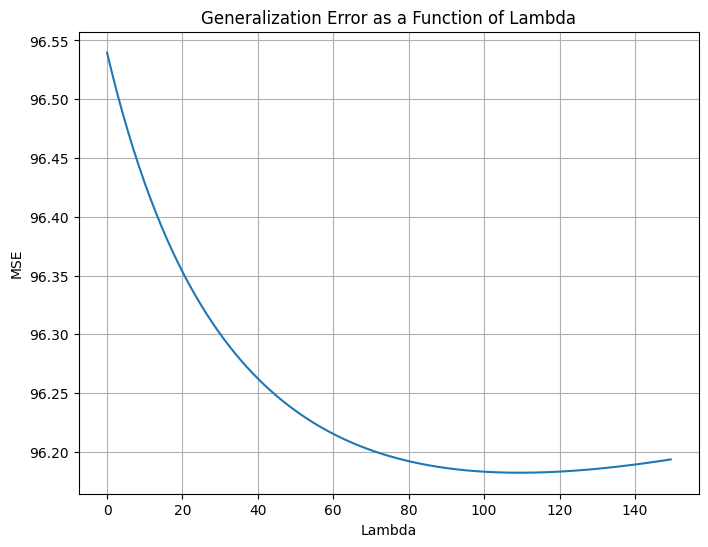

In [10]:
mean_test_scores = -results.cv_results_['mean_test_score']

plt.figure(figsize=(8, 6))
plt.plot(lambda_values, mean_test_scores)
plt.xlabel('Lambda')
plt.ylabel('MSE')
plt.title('Generalization Error as a Function of Lambda')
plt.grid(True)
plt.show()


In [ ]:
print(tabulate(cv_table, headers="keys" ,tablefmt='latex_raw', showindex=False))

Feature Weights:
      Feature    Weight
6    alcohol  0.574259
5    obesity  0.508516
4    famhist  0.095258
1    tobacco  0.079942
2        ldl  0.062867
0        sbp -0.060719
3  adiposity -0.128584
7        age -1.034591
\begin{tabular}{lr}
\hline
 Feature   &     Weight \\
\hline
 alcohol   &  0.574259  \\
 obesity   &  0.508516  \\
 famhist   &  0.095258  \\
 tobacco   &  0.0799416 \\
 ldl       &  0.0628667 \\
 sbp       & -0.0607193 \\
 adiposity & -0.128584  \\
 age       & -1.03459   \\
\hline
\end{tabular}


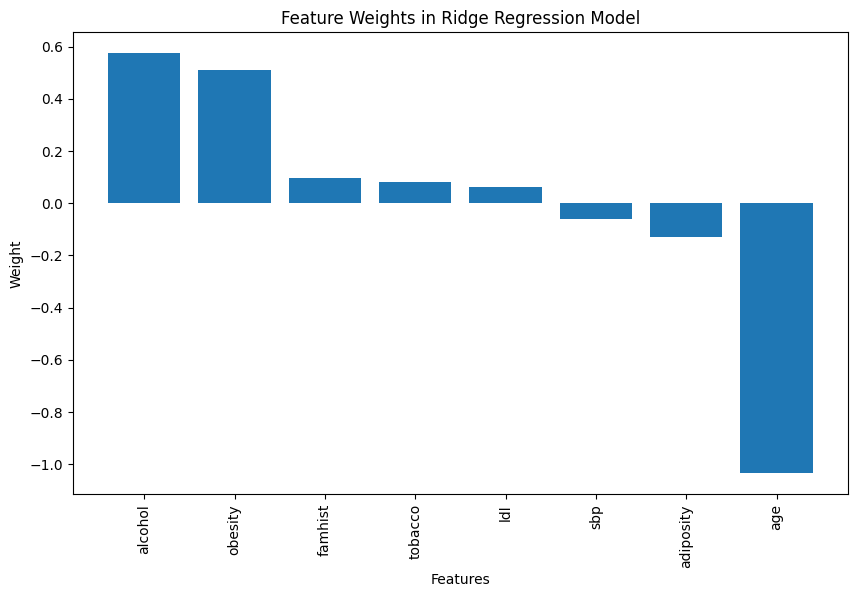

In [14]:
# Extract feature weights after training the model with the optimal lambda
feature_weights = model.coef_

# Get the feature names (column names from the dataset)
feature_names = data.drop(data.columns[[5, 9]], axis=1).columns

# Create a DataFrame to view feature weights with their names for easier interpretation
weights_df = pd.DataFrame({'Feature': feature_names, 'Weight': feature_weights})
weights_df = weights_df.sort_values(by='Weight', ascending=False)

print("Feature Weights:\n", weights_df)
print(tabulate(weights_df, headers="keys" ,tablefmt='latex_raw', showindex=False))

# Optional: Plot the weights for a visual representation
plt.figure(figsize=(10, 6))
plt.bar(weights_df['Feature'], weights_df['Weight'])
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Weight')
plt.title('Feature Weights in Ridge Regression Model')
plt.show()


### Third point
> Explain how the output, y, of the linear model with the lowest generalization
error (as determined in the previous question) is computed for a given input
x. What is the effect of an individual attribute in x on the output, y, of the
linear model? Does the effect of individual attributes make sense based on your
understanding of the problem?

The output is computed by calculating the weighted sum of the input features with regularization. Each attribute x_i contributes to the output y in proportion to its weight w_i. This is done in a way that a positive weight will increase y as x_i increases, and a negative weight would do the opposite. The magnitue of w_i would then reflect on the sensitivity of these changes, or how much changes in x_i imapct y.

# Regression, part b

> In this section, we will compare three models: the regularized
linear regression model from the previous section, an artificial neural network (ANN)
and a baseline. We are interested in two questions: Is one model better than the
other? Is either model better than a trivial baseline?. We will attempt to answer
these questions with two-level cross-validation.

### First point
Implement two-level cross-validation (see algorithm 6 of the lecture notes). We
will use 2-level cross-validation to compare the models with $K_1 = K_2 = 10$ folds
. As a baseline model, we will apply a linear regression model with no
features, i.e. it computes the mean of y on the training data, and use this value
to predict y on the test data.
Make sure you can fit an ANN model to the data. As complexity-controlling
parameter for the ANN, we will use the number of hidden units h. Based on
a few test-runs, select a reasonable range of values for h (which should include
h = 1), and describe the range of values you will use for h and λ.

In [10]:
# Two-level cross-validation

import warnings
warnings.filterwarnings("ignore")

K1, K2 = 10, 10

# Outer CV
outerCV = KFold(n_splits=K1, shuffle=True, random_state=1)

scores_baseline = []
scores_regression = []
scores_ann = []

cv_table = []

for i, (train_idx, test_idx) in enumerate(outerCV.split(X), start=1):
    # Split the data
    X_train, X_test = X[train_idx, :], X[test_idx, :]
    y_train, y_test = y[train_idx], y[test_idx]

    # Standardize values
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Baseline Model
    y_pred_baseline = np.full_like(y_test, y_train.mean())
    mse_baseline = mean_squared_error(y_test, y_pred_baseline)
    scores_baseline.append(mse_baseline)

    print(f'MSE baseline: {mse_baseline}')

    # Inner CV
    innerCV = KFold(n_splits=K2, shuffle=True, random_state=1)

    # Linear Regression
    regression = Ridge()

    lambda_values = np.arange(0, 150, 0.5)
    grid_regression = {'alpha': lambda_values}

    search_regression = GridSearchCV(regression, grid_regression, scoring='neg_mean_squared_error', cv=innerCV)
    result_regression = search_regression.fit(X_train, y_train)

    best_regression = search_regression.best_estimator_
    y_pred_regression = best_regression.predict(X_test)
    mse_regression = mean_squared_error(y_test, y_pred_regression)
    scores_regression.append(mse_regression)

    print('> mse_regression=%.3f, est=%.3f, cfg=%s' % (mse_regression, result_regression.best_score_, result_regression.best_params_))

    # Feed-forward Neural Network Model
    ann = MLPRegressor(max_iter=10000)

    h_values = [(h,) for h in np.arange(1, 50, 10)] 
    grid_ann = {'hidden_layer_sizes': h_values}

    search_ann = GridSearchCV(ann, grid_ann, scoring='neg_mean_squared_error', cv=innerCV)
    result_ann = search_ann.fit(X_train, y_train)

    best_ann = search_ann.best_estimator_
    y_pred_ann = best_ann.predict(X_test)
    mse_ann = mean_squared_error(y_test, y_pred_ann)
    scores_ann.append(mse_ann)

    print('> mse_ann=%.3f, est=%.3f, cfg=%s' % (mse_ann, result_ann.best_score_, result_ann.best_params_))

    cv_table.append({
        'Outer Fold': i,
        'h*_i (ANN)': result_ann.best_params_['hidden_layer_sizes'][0],
        'E_i^test (ANN)': mse_ann,
        'λ*_i (Ridge)': result_regression.best_params_['alpha'],
        'E_i^test (Ridge)': mse_regression,
        'E_i^test (Baseline)': mse_baseline
    })

print('MSE Baseline: %.3f (%.3f)' % (np.mean(scores_baseline), np.std(scores_baseline)))
print('MSE Regression: %.3f (%.3f)' % (np.mean(scores_regression), np.std(scores_regression)))
print('MSE ANN: %.3f (%.3f)' % (np.mean(scores_ann), np.std(scores_ann)))



MSE baseline: 112.91489361702128
> mse_regression=119.936, est=-93.327, cfg={'alpha': 101.0}
> mse_ann=116.244, est=-111.344, cfg={'hidden_layer_sizes': (11,)}
MSE baseline: 136.08510638297872
> mse_regression=137.737, est=-90.301, cfg={'alpha': 127.5}
> mse_ann=151.759, est=-104.922, cfg={'hidden_layer_sizes': (11,)}
MSE baseline: 99.69565217391305
> mse_regression=93.081, est=-95.849, cfg={'alpha': 149.5}
> mse_ann=104.953, est=-111.541, cfg={'hidden_layer_sizes': (11,)}
MSE baseline: 80.8695652173913
> mse_regression=85.830, est=-96.552, cfg={'alpha': 62.5}
> mse_ann=95.107, est=-108.053, cfg={'hidden_layer_sizes': (11,)}
MSE baseline: 85.30434782608695
> mse_regression=75.428, est=-99.214, cfg={'alpha': 149.5}
> mse_ann=89.893, est=-114.822, cfg={'hidden_layer_sizes': (11,)}
MSE baseline: 94.34782608695652
> mse_regression=88.569, est=-97.144, cfg={'alpha': 149.5}
> mse_ann=103.281, est=-114.958, cfg={'hidden_layer_sizes': (11,)}
MSE baseline: 104.19565217391305
> mse_regression=10

### Second point
Produce a table akin to Table 1 using two-level cross-validation (algorithm 6
in the lecture notes). The table shows, for each of the K1 = 10 folds i, the
optimal value of the number of hidden units and regularization strength ($h^*_i$ and $λ^*_i$ respectively) as found after each inner loop, as well as the estimated generalization errors $E^{test}_i$ by evaluating on $D^{test}_i$. It also includes the baseline
test error, also evaluated on $D^{test}_i$. Importantly, you must re-use the train/test
splits $D^{par}_i$, $D^{test}_i$ for all three methods to allow statistical comparison (see next
section).
Note the error measure we use is the squared loss per observation, i.e. we divide
by the number of observation in the test dataset:

$
\begin{equation}
E = \frac{1}{N^{test}} \sum^{N^{test}}_{i=1} (y_i − \hat y_i)^2
\end{equation}
$

Include a table similar to Table 1 in your report and briefly discuss what it tells
you at a glance. Do you find the same value of $λ^*$ as in the previous section?

In [11]:
cv_table = pd.DataFrame(cv_table)
print(cv_table)

   Outer Fold  h*_i (ANN)  E_i^test (ANN)  λ*_i (Ridge)  E_i^test (Ridge)  \
0           1          11      116.244098         101.0        119.936092   
1           2          11      151.758791         127.5        137.736873   
2           3          11      104.953450         149.5         93.081149   
3           4          11       95.107344          62.5         85.829731   
4           5          11       89.892785         149.5         75.428347   
5           6          11      103.280952         149.5         88.568940   
6           7          11      106.159271         149.5        102.975241   
7           8          11      110.437952         114.5         93.694216   
8           9          11       84.810301          92.5         89.896991   
9          10          11       89.168935         149.5         76.730715   

   E_i^test (Baseline)  
0           112.914894  
1           136.085106  
2            99.695652  
3            80.869565  
4            85.304348  
5 

In [ ]:

print(tabulate(cv_table, headers="keys" ,tablefmt='rounded_grid', showindex=False))

╭──────────────┬──────────────┬──────────────────┬────────────────┬────────────────────┬───────────────────────╮
│   Outer Fold │   h*_i (ANN) │   E_i^test (ANN) │   λ*_i (Ridge) │   E_i^test (Ridge) │   E_i^test (Baseline) │
├──────────────┼──────────────┼──────────────────┼────────────────┼────────────────────┼───────────────────────┤
│            1 │           11 │         116.244  │          101   │           119.936  │              112.915  │
├──────────────┼──────────────┼──────────────────┼────────────────┼────────────────────┼───────────────────────┤
│            2 │           11 │         151.759  │          127.5 │           137.737  │              136.085  │
├──────────────┼──────────────┼──────────────────┼────────────────┼────────────────────┼───────────────────────┤
│            3 │           11 │         104.953  │          149.5 │            93.0811 │               99.6957 │
├──────────────┼──────────────┼──────────────────┼────────────────┼────────────────────┼────────

In [13]:
print(tabulate(cv_table, headers="keys" ,tablefmt='latex_raw', showindex=False))

\begin{tabular}{rrrrrr}
\hline
   Outer Fold &   h*_i (ANN) &   E_i^test (ANN) &   λ*_i (Ridge) &   E_i^test (Ridge) &   E_i^test (Baseline) \\
\hline
            1 &           11 &         116.244  &          101   &           119.936  &              112.915  \\
            2 &           11 &         151.759  &          127.5 &           137.737  &              136.085  \\
            3 &           11 &         104.953  &          149.5 &            93.0811 &               99.6957 \\
            4 &           11 &          95.1073 &           62.5 &            85.8297 &               80.8696 \\
            5 &           11 &          89.8928 &          149.5 &            75.4283 &               85.3043 \\
            6 &           11 &         103.281  &          149.5 &            88.5689 &               94.3478 \\
            7 &           11 &         106.159  &          149.5 &           102.975  &              104.196  \\
            8 &           11 &         110.438  &         

### Third point
Statistically evaluate if there is a significant performance difference between the
fitted ANN, linear regression model and baseline using the methods described
in chapter 11. These comparisons will be made pairwise (ANN vs. linear
regression; ANN vs. baseline; linear regression vs. baseline). We will allow
some freedom in what test to choose. Therefore, choose either:
setup I (section 11.3): Use the paired t-test described in Box 11.3.4
setup II (section 11.4): Use the method described in Box 11.4.1)
Include p-values and confidence intervals for the three pairwise tests in your
report and conclude on the results: Is one model better than the other? Are
the two models better than the baseline? Are some of the models identical?
What recommendations would you make based on what you’ve learned?

In [14]:
K1, K2 = 10, 10

# Outer CV
outerCV = KFold(n_splits=K1, shuffle=True, random_state=1)

scores_baseline = []
scores_regression = []
scores_ann = []

for train_idx, test_idx in outerCV.split(X):
    # Split the data
    X_train, X_test = X[train_idx, :], X[test_idx, :]
    y_train, y_test = y[train_idx], y[test_idx]

    # Standardize values
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Baseline Model
    y_pred_baseline = np.full_like(y_test, y_train.mean())
    mse_baseline = mean_squared_error(y_test, y_pred_baseline)
    scores_baseline.append(mse_baseline)

    # Inner CV
    innerCV = KFold(n_splits=K2, shuffle=True, random_state=1)

    # Linear Regression
    regression = Ridge()

    lambda_values = np.arange(0, 150, 0.5)
    grid_regression = {'alpha': lambda_values}

    search_regression = GridSearchCV(regression, grid_regression, scoring='neg_mean_squared_error', cv=innerCV)
    result_regression = search_regression.fit(X_train, y_train)

    best_regression = search_regression.best_estimator_
    y_pred_regression = best_regression.predict(X_test)
    mse_regression = mean_squared_error(y_test, y_pred_regression)
    scores_regression.append(mse_regression)

    # Feed-forward Neural Network Model
    ann = MLPRegressor(max_iter=10000)

    h_values = [(h,) for h in np.arange(1, 50, 10)] 
    grid_ann = {'hidden_layer_sizes': h_values}

    search_ann = GridSearchCV(ann, grid_ann, scoring='neg_mean_squared_error', cv=innerCV)
    result_ann = search_ann.fit(X_train, y_train)

    best_ann = search_ann.best_estimator_
    y_pred_ann = best_ann.predict(X_test)
    mse_ann = mean_squared_error(y_test, y_pred_ann)
    scores_ann.append(mse_ann)

mse_baseline_array = np.array(scores_baseline)
mse_regression_array = np.array(scores_regression)
mse_ann_array = np.array(scores_ann)

diff_ann_reg = mse_ann_array - mse_regression_array
diff_ann_baseline = mse_ann_array - mse_baseline_array
diff_reg_baseline = mse_regression_array - mse_baseline_array

def compute_confidence_interval_and_p_value(diff, alpha=0.05):
    n = len(diff)
    mean_diff = np.mean(diff)
    std_diff = np.std(diff, ddof=1)
    t_stat = t.ppf(1 - alpha / 2, df=n-1)
    margin_of_error = t_stat * (std_diff / np.sqrt(n))
    ci_lower = mean_diff - margin_of_error
    ci_upper = mean_diff + margin_of_error
    t_value = mean_diff / (std_diff / np.sqrt(n))
    p_value = 2 * t.cdf(-abs(t_value), df=n-1)
    return mean_diff, (ci_lower, ci_upper), p_value

alpha = 0.05
ann_vs_reg = compute_confidence_interval_and_p_value(diff_ann_reg, alpha)
ann_vs_baseline = compute_confidence_interval_and_p_value(diff_ann_baseline, alpha)
reg_vs_baseline = compute_confidence_interval_and_p_value(diff_reg_baseline, alpha)

print("MSE Baseline: %.3f (%.3f)" % (np.mean(scores_baseline), np.std(scores_baseline)))
print("MSE Regression: %.3f (%.3f)" % (np.mean(scores_regression), np.std(scores_regression)))
print("MSE ANN: %.3f (%.3f)" % (np.mean(scores_ann), np.std(scores_ann)))

print("\nPairwise Statistical Comparisons:")

print("\nANN vs Linear Regression")
print(f"Mean Difference: {ann_vs_reg[0]:.3f}, CI: {ann_vs_reg[1]}, p-value: {ann_vs_reg[2]:.3f}")

print("\nANN vs Baseline")
print(f"Mean Difference: {ann_vs_baseline[0]:.3f}, CI: {ann_vs_baseline[1]}, p-value: {ann_vs_baseline[2]:.3f}")

print("\nLinear Regression vs Baseline")
print(f"Mean Difference: {reg_vs_baseline[0]:.3f}, CI: {reg_vs_baseline[1]}, p-value: {reg_vs_baseline[2]:.3f}")

MSE Baseline: 97.428 (16.507)
MSE Regression: 96.388 (18.347)
MSE ANN: 106.073 (20.448)

Pairwise Statistical Comparisons:

ANN vs Linear Regression
Mean Difference: 9.686, CI: (3.0238399681282377, 16.347244316978944), p-value: 0.009

ANN vs Baseline
Mean Difference: 8.645, CI: (2.2073398335070005, 15.082881485201408), p-value: 0.014

Linear Regression vs Baseline
Mean Difference: -1.040, CI: (-4.799648051276659, 2.718785084877884), p-value: 0.547
